# Eksploratorna analiza


## Priprema okruženja


In [1]:
# Import IPython.
from IPython import *
from IPython.display import *


In [2]:
# Import standard library.
import copy
import math
import numbers
import six
import time


In [3]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import sympy as sym
from mpl_toolkits.mplot3d import Axes3D


In [4]:
# Import TensorFlow.
import tensorflow as tf


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [5]:
# Import Scikit Learn.
import sklearn as sk
import sklearn.linear_model as lm


In [6]:
# Import Keras.
import keras
import keras.backend as K
import keras.layers as kl
import keras.models as km


Using TensorFlow backend.


In [7]:
# Import Shapely.
import shapely as sh
import shapely.geometry as gm


In [8]:
%matplotlib inline


In [9]:
#sym.init_printing()


In [10]:
plt.style.use('default')


In [11]:
from usefulness import *


## Učitavanje podataka


In [12]:
from limits_ticks import *


In [13]:
# Import complete data.
df = pd.concat(
    (
        read_tsv(
            'data/coordinates.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'x_0',
                'y_0',
                'x_1',
                'y_1',
                'x_2',
                'y_2'
            ]
        ),
        read_tsv(
            'data/sorted_description.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'a',
                'c',
                'b',
                'alpha',
                'gamma',
                'beta'
            ]
        ),
        read_tsv(
            'data/singular_values.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'sv_edge_0',
                'sv_edge_1',
                'sv_edge_2',
                'sv_angle_0',
                'sv_angle_1',
                'sv_angle_2'
            ]
        ),
        read_tsv(
            'data/eigenvalues.tsv',
            header = False,
            index = False,
            as_str = False,
            names = ['l_0']
        )
    ),
    axis = 1
).copy(deep = True)

# Import auxiliary balanced data.
df_balanced = pd.concat(
    (
        read_tsv(
            'data/auxiliary_coordinates.tsv',
            header = False,
            index = False,
            as_str = False,
            names = [
                'x_0',
                'y_0',
                'x_1',
                'y_1',
                'x_2',
                'y_2'
            ]
        ),
        read_tsv(
            'data/auxiliary_eigenvalues.tsv',
            header = False,
            index = False,
            as_str = False,
            names = ['l_0']
        )
    ),
    axis = 1
).copy(deep = True)


In [14]:
# Compute quantiles (20 % intervals) of lambda_0 on `df_balanced`.
l_0_quant = np.array(
    np.concatenate(
        (
            [min(df_balanced.l_0.min(), df.l_0.min())],
            [
                df_balanced.l_0.quantile(float("0.{p:02d}".format(p = i)))
                    for i in range(5, 96, 5)
            ],
            [max(df_balanced.l_0.max(), df.l_0.max())]
        )
    ),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Compute base 10 logarithms of quantiles `l_0_quant`.
l_0_log10_quant = np.array(
    np.log10(l_0_quant),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)

# Extend extreme levels by 10^(-8).
l_0_quant[0] -= 1.0e-8
l_0_quant[-1] += 1.0e-8
l_0_log10_quant[0] -= 1.0e-8
l_0_log10_quant[-1] += 1.0e-8


In [15]:
x = np.load('data/arrays/x.npy')
y = np.load('data/arrays/y.npy')

X = np.load('data/arrays/X.npy')
Y = np.load('data/arrays/Y.npy')

L_0 = np.load('data/arrays/L.npy')


In [16]:
I = np.array(
    np.isnan(L_0),
    dtype = bool,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 2
)

#L_0[I] = 1.0e-16

X = np.ma.MaskedArray(X, mask = I, copy = True, subok = False)
Y = np.ma.MaskedArray(Y, mask = I, copy = True, subok = False)
L_0 = np.ma.MaskedArray(L_0, mask = I, copy = True, subok = False)

del I


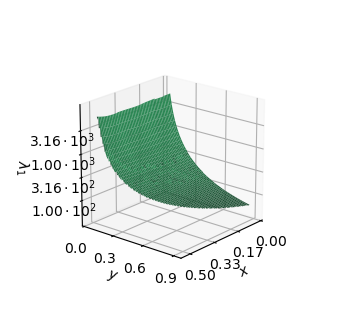

In [17]:
# Create a figure.
fig = plt.figure(num = 'Eigenvalues', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1, projection = '3d')

# Set the view of the plot.
ax.view_init(20.0, 40.0)
ax.dist = 13.5

# Plot lambda_0 as surface on the domain of characteristic points.
ax.plot_surface(X, Y, np.log10(L_0.data), color = 'seagreen')

# Set axis labels.
ax.set_xlabel("$ x $")
ax.set_ylabel("$ y $")
ax.set_zlabel("$ \lambda_{1} $", labelpad = 16)

# Set ticks.
ax.set_xticks(ticks['x_1_thirds'])
ax.set_yticks(ticks['y_1_thirds'])
ax.set_zticks(ticks['l_0_log10'])

# Set tick labels.
ax.set_xticklabels(ticklabels['x_1_thirds'])
ax.set_yticklabels(ticklabels['y_1_thirds'])
ax.set_zticklabels(ticklabels['l_0_log10'])

# Set axis limits.
ax.set_xlim((lim['x_1'][0], lim['x_1'][1] + 5.0e-2))
ax.set_ylim((lim['y_1'][0], lim['y_1'][1] + 5.0e-2))
ax.set_zlim(lim['l_0_log10'])

# Save the figure.
fig.savefig('../eigenvalues_3D.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [18]:
# Free the memory.
del fig
del ax


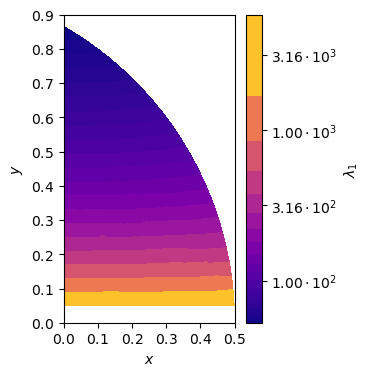

In [19]:
# Create a figure.
fig = plt.figure(num = 'Eigenvalues', figsize = (3.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set aspect of the plot to equal.
ax.set_aspect('equal')

# Plot lambda_0 as contour on the domain of characteristic points.
cs = ax.contourf(
    X,
    Y,
    np.log10(L_0),
    levels = l_0_log10_quant,
    cmap = plt.cm.plasma
)

# Set axis labels.
ax.set_xlabel("$ x $")
ax.set_ylabel("$ y $")

# Set ticks.
ax.set_xticks(ticks['x_1'])
ax.set_yticks(ticks['y_1'])

# Set tick labels.
ax.set_xticklabels(ticklabels['x_1'])
ax.set_yticklabels(ticklabels['y_1'])

# Set axis limits.
ax.set_xlim(lim['x_1'])
ax.set_ylim(lim['y_1'])

# Create a colorbar.
cbar = fig.colorbar(
    cs,
    ax = ax,
    ticks = ticks['l_0_log10'],
    spacing = 'proportional'
)

# Set label for the colorbar.
cbar.set_label("$ \lambda_{1} $")

# Set ticklabels for the colorbar.
cbar.ax.set_yticklabels(ticklabels['l_0_log10'])

# Save the figure.
fig.savefig('../eigenvalues.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [20]:
# Free the memory.
del fig
del ax


In [21]:
# Free the memory.
del x
del y
del X
del Y
del L_0
del df_balanced


In [22]:
quants = tuple(
    df.loc[(df.l_0 >= l_0_quant[i]) & (df.l_0 < l_0_quant[i + 1])].copy(
        deep = True
    ) for i in range(int(l_0_quant.size) - 1)
)
try:
    del i
except (NameError, UnboundLocalError):
    pass


In [23]:
sample_df = pd.concat(
    generate_subdf(quants, 50),
    axis = 0
).sort_index(axis = 0, inplace = False).copy(deep = True)


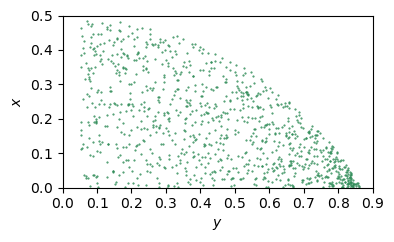

In [24]:
# Create a figure.
fig = plt.figure(num = 'Sample', figsize = (4.0, 2.25))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set aspect of the plot to equal.
ax.set_aspect('equal')

# Plot the coordinates of characteristic points from the generated sample.
ax.plot(
    sample_df.y_1,
    sample_df.x_1,
    color = 'seagreen',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ y $")
ax.set_ylabel("$ x $")

# Set ticks.
ax.set_xticks(ticks['y_1'])
ax.set_yticks(ticks['x_1'])

# Set tick labels.
ax.set_xticklabels(ticklabels['y_1'])
ax.set_yticklabels(ticklabels['x_1'])

# Set axis limits.
ax.set_xlim(lim['y_1'])
ax.set_ylim(lim['x_1'])

# Save the figure.
fig.savefig('../sample.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [25]:
# Free the memory.
del fig
del ax


In [26]:
# Free the memory.
del quants
del sample_df


## Podjela skupa podataka


In [27]:
full_index = np.load('data/arrays/full_index.npy')
train_index = np.load('data/arrays/train_index.npy')
validation_test_index = np.load('data/arrays/validation_test_index.npy')
validation_index = np.load('data/arrays/validation_index.npy')
test_index = np.load('data/arrays/test_index.npy')


In [28]:
full_df = df.loc[full_index].copy(deep = True)
train_df = df.loc[train_index].copy(deep = True)
validation_test_df = df.loc[validation_test_index].copy(deep = True)
validation_df = df.loc[validation_index].copy(deep = True)
test_df = df.loc[test_index].copy(deep = True)


In [29]:
# Free the memory.
del full_index
del train_index
del validation_test_index
del validation_index
del test_index


In [30]:
# Free the memroy.
del df


In [31]:
quants = tuple(
    train_df.loc[
        (train_df.l_0 >= l_0_quant[i]) & (train_df.l_0 < l_0_quant[i + 1])
    ].copy(deep = True) for i in range(int(l_0_quant.size) - 1)
)
try:
    del i
except (NameError, UnboundLocalError):
    pass


In [32]:
sample_df = pd.concat(
    generate_subdf(quants, 50),
    axis = 0
).sort_index(axis = 0, inplace = False).copy(deep = True)


In [33]:
# Compute quantiles (20 % intervals) of y_1 on `train_df`.
y_quant = np.array(
    np.concatenate(
        (
            [train_df.y_1.min()],
            [
                train_df.y_1.quantile(float("0.{p:02d}".format(p = i)))
                    for i in range(5, 96, 5)
            ],
            [train_df.y_1.max()]
        )
    ),
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 1
)
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Extend extreme values by 10^(-8).
y_quant[0] -= 1.0e-8
y_quant[-1] += 1.0e-8


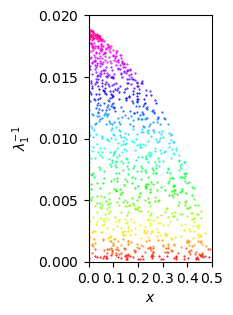

In [34]:
# Create a figure.
fig = plt.figure(num = 'Sample: x, lambda_0', figsize = (2.4, 3.2))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to 50.
ax.set_aspect(50.0)

# Generate a spectrum of n equidistant colours, where n is the number of
# quantiles of y_1.
col = rainbow(int(y_quant.size) - 1)

# Plot lambda_0 over x_1 by quantiles of y_1.  Colour each set of points the
# corresponding colour.
for i in range(int(y_quant.size) - 1):
    ax.plot(
        sample_df.loc[
            (sample_df.y_1 >= y_quant[i]) & (sample_df.y_1 < y_quant[i + 1]),
            'x_1'
        ],
        sample_df.loc[
            (sample_df.y_1 >= y_quant[i]) & (sample_df.y_1 < y_quant[i + 1]),
            'l_0'
        ] ** -1,
        color = col[i],
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del col

# Set axis labels.
ax.set_xlabel("$ x $")
ax.set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks.
ax.set_xticks(ticks['x_1'])
ax.set_yticks(ticks['l_0_inv'])

# Set tick labels.
ax.set_xticklabels(ticklabels['x_1'])
ax.set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits.
ax.set_xlim(lim['x_1'])
ax.set_ylim(lim['l_0_inv'])

# Save the figure.
fig.savefig('../x-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [35]:
# Free the memory.
del fig
del ax


In [36]:
# Free the memory.
del y_quant


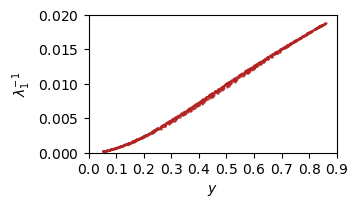

In [37]:
# Create a figure.
fig = plt.figure(num = 'Sample: y, lambda_0', figsize = (3.2, 2.4))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to 25.
ax.set_aspect(25.0)

# Plot lambda_0 over y_1.
ax.plot(
    sample_df.y_1,
    sample_df.l_0 ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ y $")
ax.set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks.
ax.set_xticks(ticks['y_1'])
ax.set_yticks(ticks['l_0_inv'])

# Set tick labels.
ax.set_xticklabels(ticklabels['y_1'])
ax.set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits.
ax.set_xlim(lim['y_1'])
ax.set_ylim(lim['l_0_inv'])

# Save the figure.
fig.savefig('../y-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [38]:
# Free the memory.
del fig
del ax


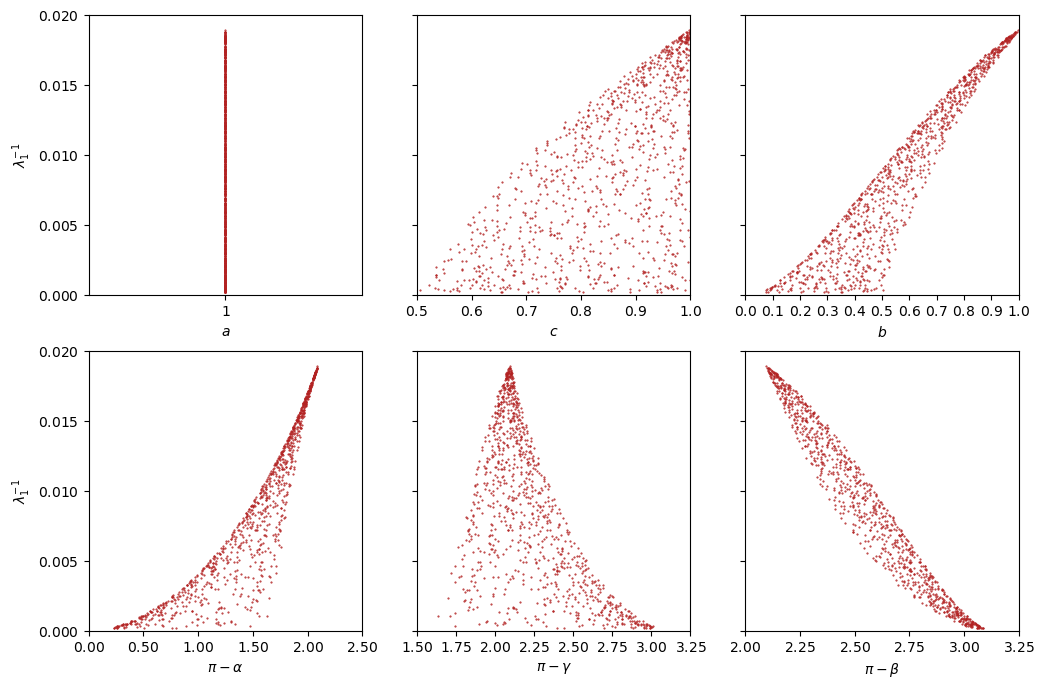

In [39]:
# Create a figure and 2 x 3 subplots.
fig, ax = plt.subplots(
    num = 'Sample: edges/angles, lambda_0',
    figsize = (12.0, 8.0),
    nrows = 2,
    ncols = 3,
    sharex = False,
    sharey = True
)

# Define names of edges and angles.
edge = ('a', 'c', 'b')
angle = ('alpha', 'gamma', 'beta')

# Plot lambda_0 over the lengths of edges in the top row of subplots.
for i in range(3):
    # Plot the data.
    ax[0, i].plot(
        sample_df[edge[i]],
        sample_df.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[0, i].set_xlabel("$ {e:s} $".format(e = edge[i]))
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Plot lambda_0 over the outer angles in the bottom row of subplots.
for i in range(3):
    # Plot the data.
    ax[1, i].plot(
        sample_df[angle[i]],
        sample_df.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the y-axis label.
    ax[1, i].set_xlabel("$ \\pi - \\{a:s} $".format(a = angle[i]))
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set the y-axis label on the leftmost subplots in each row.
for i in range(2):
    ax[i, 0].set_ylabel("$ \\lambda_{1}^{{- 1}} $")
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set ticks, tick labels and limits of the subplots.
for i in range(2):
    for j in range(3):
        # Set ticks.
        ax[i, j].set_xticks(ticks[angle[j] if i else edge[j]])
        ax[i, j].set_yticks(ticks['l_0_inv'])

        # Set tick labels.
        ax[i, j].set_xticklabels(ticklabels[angle[j] if i else edge[j]])
        ax[i, j].set_yticklabels(ticklabels['l_0_inv'])

        # Set axis limits.
        ax[i, j].set_xlim(lim[angle[j] if i else edge[j]])
        ax[i, j].set_ylim(lim['l_0_inv'])
    try:
        del j
    except (NameError, UnboundLocalError):
        pass
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del edge
del angle

# Save the figure.
fig.savefig('../edge_angle-lambda.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


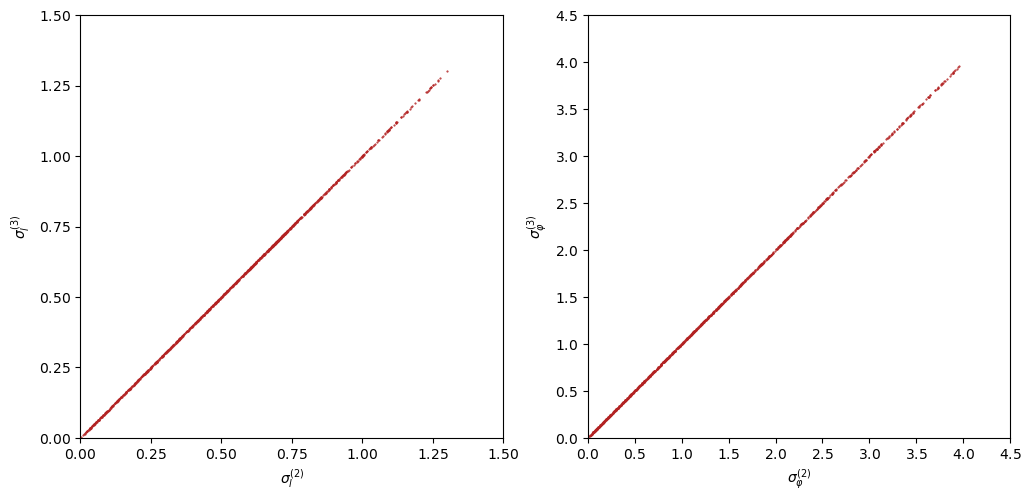

In [40]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Sample: singular values',
    figsize = (12.0, 6.75),
    nrows = 1,
    ncols = 2
)

# Set aspects of subplots to equal.
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# Plot sv_edge_2 over sv_edge_1 on the left plot.
ax[0].plot(
    sample_df.sv_edge_1,
    sample_df.sv_edge_2,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Plot sv_angle_2 over sv_angle_1 on the right plot.
ax[1].plot(
    sample_df.sv_angle_1,
    sample_df.sv_angle_2,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels on the left plot.
ax[0].set_xlabel("$ \\sigma_{l}^{\\left( 2 \\right)} $")
ax[0].set_ylabel("$ \\sigma_{l}^{\\left( 3 \\right)} $")

# Set ticks on the left plot.
ax[0].set_xticks(ticks['sv_edge_1'])
ax[0].set_yticks(ticks['sv_edge_2'])

# Set tick labels on the left plot.
ax[0].set_xticklabels(ticklabels['sv_edge_1'])
ax[0].set_yticklabels(ticklabels['sv_edge_2'])

# Set axis limits on the left plot.
ax[0].set_xlim(lim['sv_edge_1'])
ax[0].set_ylim(lim['sv_edge_2'])

# Set axis labels on the right plot.
ax[1].set_xlabel("$ \\sigma_{\\varphi}^{\\left( 2 \\right)} $")
ax[1].set_ylabel("$ \\sigma_{\\varphi}^{\\left( 3 \\right)} $")

# Set ticks on the right plot.
ax[1].set_xticks(ticks['sv_angle_1'])
ax[1].set_yticks(ticks['sv_angle_2'])

# Set tick labels on the right plot.
ax[1].set_xticklabels(ticklabels['sv_angle_1'])
ax[1].set_yticklabels(ticklabels['sv_angle_2'])

# Set axis limits on the right plot.
ax[1].set_xlim(lim['sv_angle_1'])
ax[1].set_ylim(lim['sv_angle_2'])

# Save the figure.
fig.savefig('../sv-sv.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [41]:
# Free the memory.
del fig
del ax


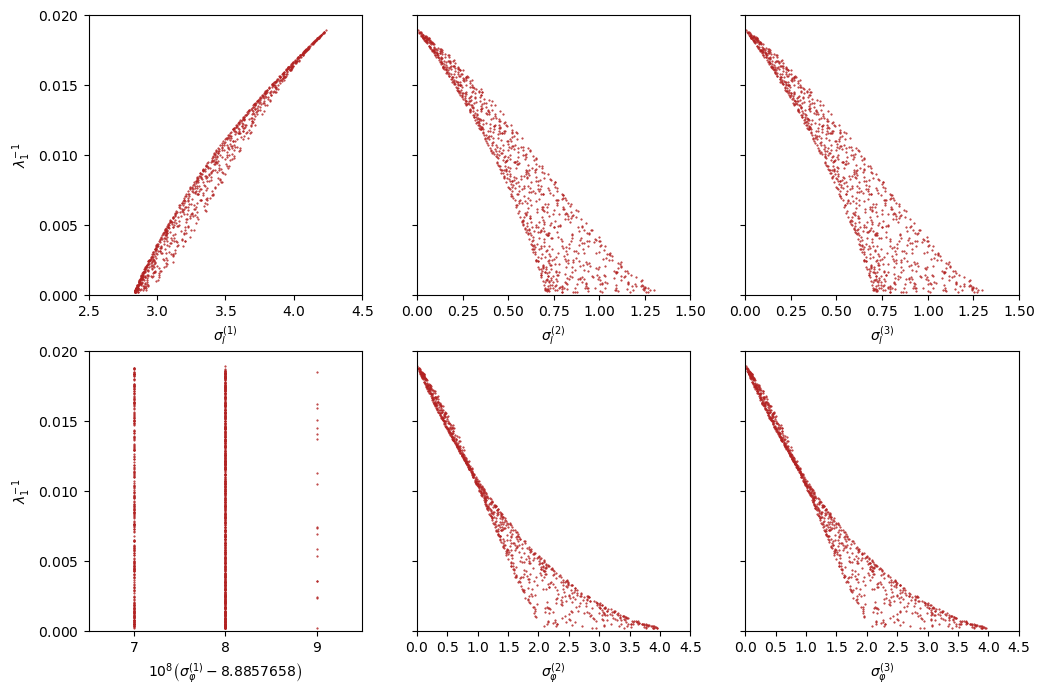

In [42]:
# Create a figure and 2 x 3 subplots.
fig, ax = plt.subplots(
    num = 'Sample: singular values, lambda_0',
    figsize = (12.0, 8.0),
    nrows = 2,
    ncols = 3,
    sharex = False,
    sharey = True
)

# Plot lambda_0 over the singular values of the lengths of edges in the top row
# of subplots.
for i in range(3):
    # Plot the data.
    ax[0, i].plot(
        sample_df["sv_edge_{ind:d}".format(ind = i)],
        sample_df.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[0, i].set_xlabel(
        "$ \\sigma_{{l}}^{{\\left( {ind:d} \\right)}} $".format(ind = i + 1)
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Plot lambda_0 over the singular values of the outer angles in the bottom row
# of subplots.
for i in range(3):
    # Plot the data.
    ax[1, i].plot(
        sample_df["sv_angle_{ind:d}".format(ind = i)],
        sample_df.l_0 ** -1,
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

    # Set the x-axis label.
    ax[1, i].set_xlabel(
        (
            "$ \\sigma_{{\\varphi}}^{{\\left( {ind:d} \\right)}} $"
                if i else (
                    "$ 10^{{8}} \\left( \\sigma_{{\\varphi}}^{{\\left( "
                        "{ind:d} \\right)}} - 8.8857658 \\right) $"
                )
        ).format(ind = i + 1)
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set the y-axis label on the leftmost subplots in each row.
for i in range(2):
    ax[i, 0].set_ylabel("$ \\lambda_{1}^{{- 1}} $")
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set ticks, tick labels and limits of the subplots.
for i in range(2):
    for j in range(3):
        # Set ticks.
        ax[i, j].set_xticks(
            ticks[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_yticks(ticks['l_0_inv'])

        # Set tick labels.
        ax[i, j].set_xticklabels(
            ticklabels[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_yticklabels(ticklabels['l_0_inv'])

        # Set axis limits.
        ax[i, j].set_xlim(
            lim[
                "sv_{arg:s}_{ind:d}".format(
                    arg = 'angle' if i else 'edge',
                    ind = j
                )
            ]
        )
        ax[i, j].set_ylim(lim['l_0_inv'])
    try:
        del j
    except (NameError, UnboundLocalError):
        pass
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure.
fig.savefig('../sv-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [43]:
# Free the memory.
del fig
del ax


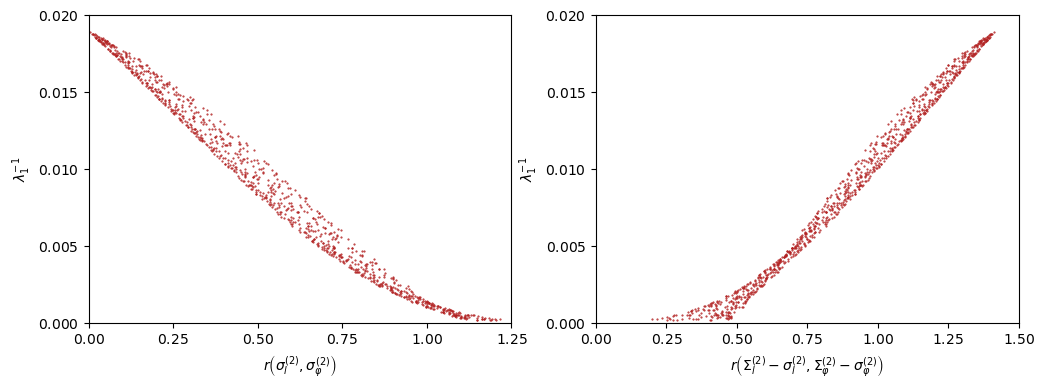

In [44]:
# Create a figure and subplots.
fig, ax = plt.subplots(
    num = 'Sample: r(sv_edge_1, sv_angle_1), lambda_0',
    figsize = (12.0, 4.0),
    nrows = 1,
    ncols = 2
)

# Plot lambda_0 over r(sv_edge_1, sv_angle_1) on the left plot.
ax[0].plot(
    np.sqrt(
        (sample_df.sv_edge_1 / train_df.sv_edge_1.max()) ** 2 +
        (sample_df.sv_angle_1 / train_df.sv_angle_1.max()) ** 2
    ),
    sample_df.l_0 ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Plot lambda_0 over r(inv sv_edge_1, inv sv_angle_1) on the right plot.
ax[1].plot(
    np.sqrt(
        (
            (train_df.sv_edge_1.max() - sample_df.sv_edge_1) /
            train_df.sv_edge_1.max()
        ) ** 2 +
        (
            (train_df.sv_angle_1.max() - sample_df.sv_angle_1) /
            train_df.sv_angle_1.max()
        ) ** 2
    ),
    sample_df.l_0 ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels on the left plot.
ax[0].set_xlabel(
    "$ "
        "r \\left( "
            "\\sigma_{l}^{\\left( 2 \\right)} , "
            "\\sigma_{\\varphi}^{\\left( 2 \\right)} "
        "\\right) "
    "$"
)
ax[0].set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks on the left plot.
ax[0].set_xticks(ticks['r(sv_edge_1, sv_angle_1)'])
ax[0].set_yticks(ticks['l_0_inv'])

# Set tick labels on the left plot.
ax[0].set_xticklabels(ticklabels['r(sv_edge_1, sv_angle_1)'])
ax[0].set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits on the left plot.
ax[0].set_xlim(lim['r(sv_edge_1, sv_angle_1)'])
ax[0].set_ylim(lim['l_0_inv'])

# Set axis labels on the right plot.
ax[1].set_xlabel(
    "$ "
        "r \\left( "
            "\\Sigma_{l}^{\\left( 2 \\right)} - "
                "\\sigma_{l}^{\\left( 2 \\right)} , "
            "\\Sigma_{\\varphi}^{\\left( 2 \\right)} - "
                "\\sigma_{\\varphi}^{\\left( 2 \\right)} "
        "\\right) "
    "$"
)
ax[1].set_ylabel("$ \lambda_{1}^{{- 1}} $")

# Set ticks on the right plot.
ax[1].set_xticks(ticks['r(inv sv_edge_1, inv sv_angle_1)'])
ax[1].set_yticks(ticks['l_0_inv'])

# Set tick labels on the right plot.
ax[1].set_xticklabels(ticklabels['r(inv sv_edge_1, inv sv_angle_1)'])
ax[1].set_yticklabels(ticklabels['l_0_inv'])

# Set axis limits on the right plot.
ax[1].set_xlim(lim['r(inv sv_edge_1, inv sv_angle_1)'])
ax[1].set_ylim(lim['l_0_inv'])

# Save the figure.
fig.savefig('../r(sv,sv)-lambda.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()
